Yonaton chanowitz
07/21/2022
Data Science Flex
Instructor: Morgan Jones

Rainbow Six Siege (R6S) is a highly competative first person shooter video game

### Contents

- Problem
- Data source explanation
- Data Exploration
    - Values
    - Charts
- Double Checkup
- Modeling
    - Base model DecisionTree
        - Gridsearch
        - Double check
        - Secondary Model
    - Second model KNearestNeighbors
        - Gridsearch
        - Secondary model
    - Third model RandomForest
        - Gridsearch
        - Secondary model
    - Final Model
- Results
    - Conclusion
    - Suggestions

### Steakholder

me, or any R6S player wanting to improve win percentage

# Problem
R6S map knowledge, gadget usage, and operator loadout mean just as much as ability to shoot. Personally i don't have that high of a rank, and wondered:
#### what would help me get an edge on the competition leading to more wins overall?
let's find out which mixture of features leads to a win 

### I will be judging model primarily by it's f1 score, and using models that are best for categorization. 
as we will see that all of the variables that i am using are categorical, and the target variaqble is binary

# Data Source Explanation
Season 5 data (2012 - 2017)

the data we are using is directly from Ubisoft (the makers of R6S), from season 5 in 2018. it has several thousands of matches and the details of what players chose, the outcome of the match, and the players rank.

A good source for seeing how we can classify which decisions led to a win

<font color='red'> The csv file included with this notebook (data_slice.csv) is for demonstration purposes only.The full set of files contains 20 csv files, each a Gigabyte large.  </font>

the full data set can be downloaded from here: https://www.kaggle.com/datasets/maxcobra/rainbow-six-siege-s5-ranked-dataset?resource=download&select=datadump_s5-000.csv 

In [1]:
# import neccessay libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

%matplotlib inline
import seaborn as sns


this data set is **HUGE**. i am going to run my models on about 2% of it, for computational speed

to make an easier to work with sub-set, i will
1) read the first (of 20) csv files, only read the first 100,000 rows <br>
2) save the sliced sub-set of data into a csv file for others to be able to use <br>
3) use the sub-set for working on

i can then load the rest of the data as a test set for more thorough testing

In [2]:
#i want to read all the columns
pd.set_option('display.max_columns', None)

# make a pandas dataframe using only 100,000 rows. 
first_set = pd.read_csv('r6s_data/datadump_s5-000.csv',  nrows=100000)

# save the new sub set of data for use by other people exploring this notebook
first_set.to_csv('uploadable_data/data_slice.csv')

# first_set.head(5)

data = pd.read_csv('uploadable_data/data_slice.csv')
data.head()

,Unnamed: 0,dateid,platform,gamemode,mapname,matchid,roundnumber,objectivelocation,winrole,endroundreason,roundduration,clearancelevel,skillrank,role,team,haswon,operator,nbkills,isdead,primaryweapon,primaryweapontype,primarysight,primarygrip,primaryunderbarrel,primarybarrel,secondaryweapon,secondaryweapontype,secondarysight,secondarygrip,secondaryunderbarrel,secondarybarrel,secondarygadget
0,0,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,1,STRIP_CLUB,Defender,AttackersKilledHostage,124,64,Gold,Defender,1,1,SWAT-CASTLE,0,0,UMP45,Submachine_Guns,RedDot,Vertical,None,Compensator,5.7_USG,Pistols,None,None,None,None,IMPACT_GRENADE
1,1,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,4,CHURCH,Defender,AttackersEliminated,217,81,Gold,Defender,0,1,GSG9-JAGER,0,1,416-C_CARBINE,Assault_Rifles,RedDot,Vertical,Laser,Suppressor,P12,Pistols,None,None,Laser,Suppressor,DEPLOYABLE_SHIELD
2,2,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,3,CHURCH,Defender,AttackersEliminated,160,150,Gold,Defender,1,1,JTF2-FROST,0,0,9mm_C1,Submachine_Guns,Reflex,None,None,None,MK1_9mm,Pistols,None,None,None,None,DEPLOYABLE_SHIELD
3,3,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,4,CHURCH,Defender,AttackersEliminated,217,94,Gold,Defender,0,1,BOPE-CAVEIRA,3,0,M12,Submachine_Guns,RedDot,None,None,MuzzleBrake,PRB92,Pistols,None,None,None,None,IMPACT_GRENADE
4,4,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,6,BEDROOM,Attacker,DefendersEliminated,143,81,Gold,Defender,0,0,GSG9-JAGER,0,1,416-C_CARBINE,Assault_Rifles,RedDot,Vertical,Laser,Suppressor,P12,Pistols,None,None,Laser,Suppressor,DEPLOYABLE_SHIELD




# Data exploration

this will be two parts
1) exploration of values <br>
2) charts
## part 1

- let's see if there is  any missing values <br>
- what data types are present <br>

In [3]:
# look at the column names and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Unnamed: 0            100000 non-null  int64 
 1   dateid                100000 non-null  int64 
 2   platform              100000 non-null  object
 3   gamemode              100000 non-null  object
 4   mapname               100000 non-null  object
 5   matchid               100000 non-null  int64 
 6   roundnumber           100000 non-null  int64 
 7   objectivelocation     100000 non-null  object
 8   winrole               100000 non-null  object
 9   endroundreason        100000 non-null  object
 10  roundduration         100000 non-null  int64 
 11  clearancelevel        100000 non-null  int64 
 12  skillrank             100000 non-null  object
 13  role                  100000 non-null  object
 14  team                  100000 non-null  int64 
 15  haswon            

we see that
- there are no null values
- the majority of variables are objects
- looking at the head data, all the objects are categorical

#### note:
i went through all the other data, there are no null values in any of the 20Gb
<br>
<br>
<br>
the data here appears to be from 2012. i will run my final model against the 20th csv file, just to be sure it works, because a few things have changed from 2012 - 2018
<br>
<br>
### list of all the values in each column
i want a list of all the values in each column, since **ubisoft didn't provide information on the meaning of the columns**

In [4]:
for column in data:
    print(data[column].unique())

[    0     1     2 ... 99997 99998 99999]
[20170212]
['PC' 'PS4' 'XONE']
['HOSTAGE' 'BOMB' 'SECURE_AREA']
['CLUB_HOUSE' 'PLANE' 'KANAL' 'HEREFORD_BASE' 'CONSULATE' 'YACHT' 'OREGON'
 'BORDER' 'SKYSCRAPER' 'BANK' 'COASTLINE' 'BARTLETT_U.' 'HOUSE'
 'KAFE_DOSTOYEVSKY' 'FAVELAS' 'CHALET']
[1522380841 1522488121 1522514641 ... 1817304881 1817496761 1817583741]
[1 4 3 6 2 5 7 8 9]
['STRIP_CLUB' 'CHURCH' 'BEDROOM' 'CASH_ROOM'
 'MEETING_ROOM-EXECUTIVE_OFFICE' 'CARGO_HOLD-LUGGAGE_HOLD'
 'STAFF_SECTION-EXECUTIVE_BEDROOM' 'SERVER_ROOM-CONTROL_ROOM'
 'COAST_GUARD_OFFICE-HOLDING_ROOM' 'KITCHEN-PROJECTOR_ROOM' 'ARMORY'
 'MASTER_BEDROOM' 'ARCHIVES' 'GARAGE' 'COCKPIT' 'KITCHEN-DINING_HALL'
 'KIDS_DORMS-DORMS_MAIN_HALL' 'REAR_STAGE-WATCH_TOWER' 'CASINO'
 'MAPS_ROOM' 'ENGINE' 'LAUDRY_ROOM-SUPPLY_ROOM' 'KITCHEN-ENGINE_CONTROL'
 'MAPS_ROOM-COCKPIT' 'MEETING_ROOM' 'LUGGAGE_HOLD' 'TELLERS' 'OFFICES'
 'ARMORY_LOCKERS' 'WORKSHOP' '2F_TEA_ROOM' '1F_BEDROOM' '1F_BBQ'
 '2F_WORK_OFFICE' 'LOCKERS' 'OPEN_AREA' 'ARSE

the meaning of each column, i had to gather from inspecting the actual game

 0   'dateid'                the date the match occured<br>
 1   'platform'              the gaming hardware used [PC, Playstation, or XBox]<br>
 2   'gamemode'              the game mode played ['HOSTAGE' 'BOMB' 'SECURE_AREA'] <br>
 3   'mapname'               the map that was chosen to be played in<br>
 4   'matchid'               ubisoft's assigned match id number <br>
 5   'roundnumber'           the round of the match  [1 4 3 6 2 5 7 8 9]<br>
 6   'objectivelocation'     the ROOM on each map that the objective was placed in<br>
 7   'winrole'               the role that the winners had (either ['Defender' 'Attacker'] )<br>
 8   'endroundreason'        what led to the round finishing<br>
 9   'roundduration'         the duration of the round in seconds of in game time<br> 
 10  'clearancelevel'        the clearance level of the player <br>
         (clearance level usually reflects length of overall time playing the game)<br>
 11  'skillrank'             the skill rank of the player<br>
 12  'role'                  the role the player had in the match<br>
 13  'team'                  (not sure. this is a boolean value, which leads me to think it's<br>
         "is the player on a team" but that's purely assumption) <br>
 14  'haswon'                boolean value if the player won. 1 for win, 0 for loss<br> 
 15  'operator'              the operator chosen by the player<br>
 16  'nbkills'               the number of kills the player had in that round<br> 
 17  'isdead'                if the player died that round <br>
 18  'primaryweapon'         the operators primary weapon chosen<br>
 19  'primaryweapontype'     the type of the primary weapon chosen <br>
         (different types have different 1) accuracy, 2) rate of fire 3) damage per shot. these effect playstyle)<br>
 20  'primarysight'          the sights chosen for the primary weapon (these effect accuracy of shooting)<br>
 21  'primarygrip'           type of grip used on primary <br>
         (this effects kickback. the guns in seige perform similar to irl guns, having kickback)<br>
 22  'primaryunderbarrel'    primary weapon under barrel attachment<br>
 23  'primarybarrel'         primary weapon barrel attachment<br>
 24  'secondaryweapon'       secondary weapon chosen<br>
 25  'secondaryweapontype'   type of secondary weapon chosen (type is similar reason to primary weapon)<br>
 26  'secondarysight'        sight chosen for secondary weapon<br>
 27  'secondarygrip'         grip used on secondary weapon<br>
 28  'secondaryunderbarrel'  under barrel attachment of secondary weapon<br>
 29  'secondarybarrel'       barrel attachment of secondary weapon<br>
 30  'secondarygadget'       secondary gadget chosen<br>

we need to filter the DB to only `'gamemode' == 'BOMB'`, because in competitive play, only bomb is used

In [5]:
only_bomb = data.loc[data['gamemode'] == 'BOMB']

# Data exploration
## part 2
i want to make a dummies data set, to see how the data is distributed, by using a heatmap and barchart

## Limitations

like any First Person Shooter, aim is important. being that only recently Ubisoft has started tracking aim and accuracy, and the fact that they do not release that data, presents a challenge in that the classification will not be enough to truly predict a potential win.

hopefully AimLabs or Ubisoft will release that data, but i'm sceptical 

make a dataframe with dummy values for making a heatmap

In [6]:
# make a seperate dataframe with dummies just to generate a seaborn heatmap

filtered = only_bomb.drop(['matchid', 'dateid', 'roundduration', 'endroundreason', 'clearancelevel', 'skillrank', 'team'], axis=1)
dummy_bomb = pd.get_dummies(filtered, drop_first=True)

<AxesSubplot:>

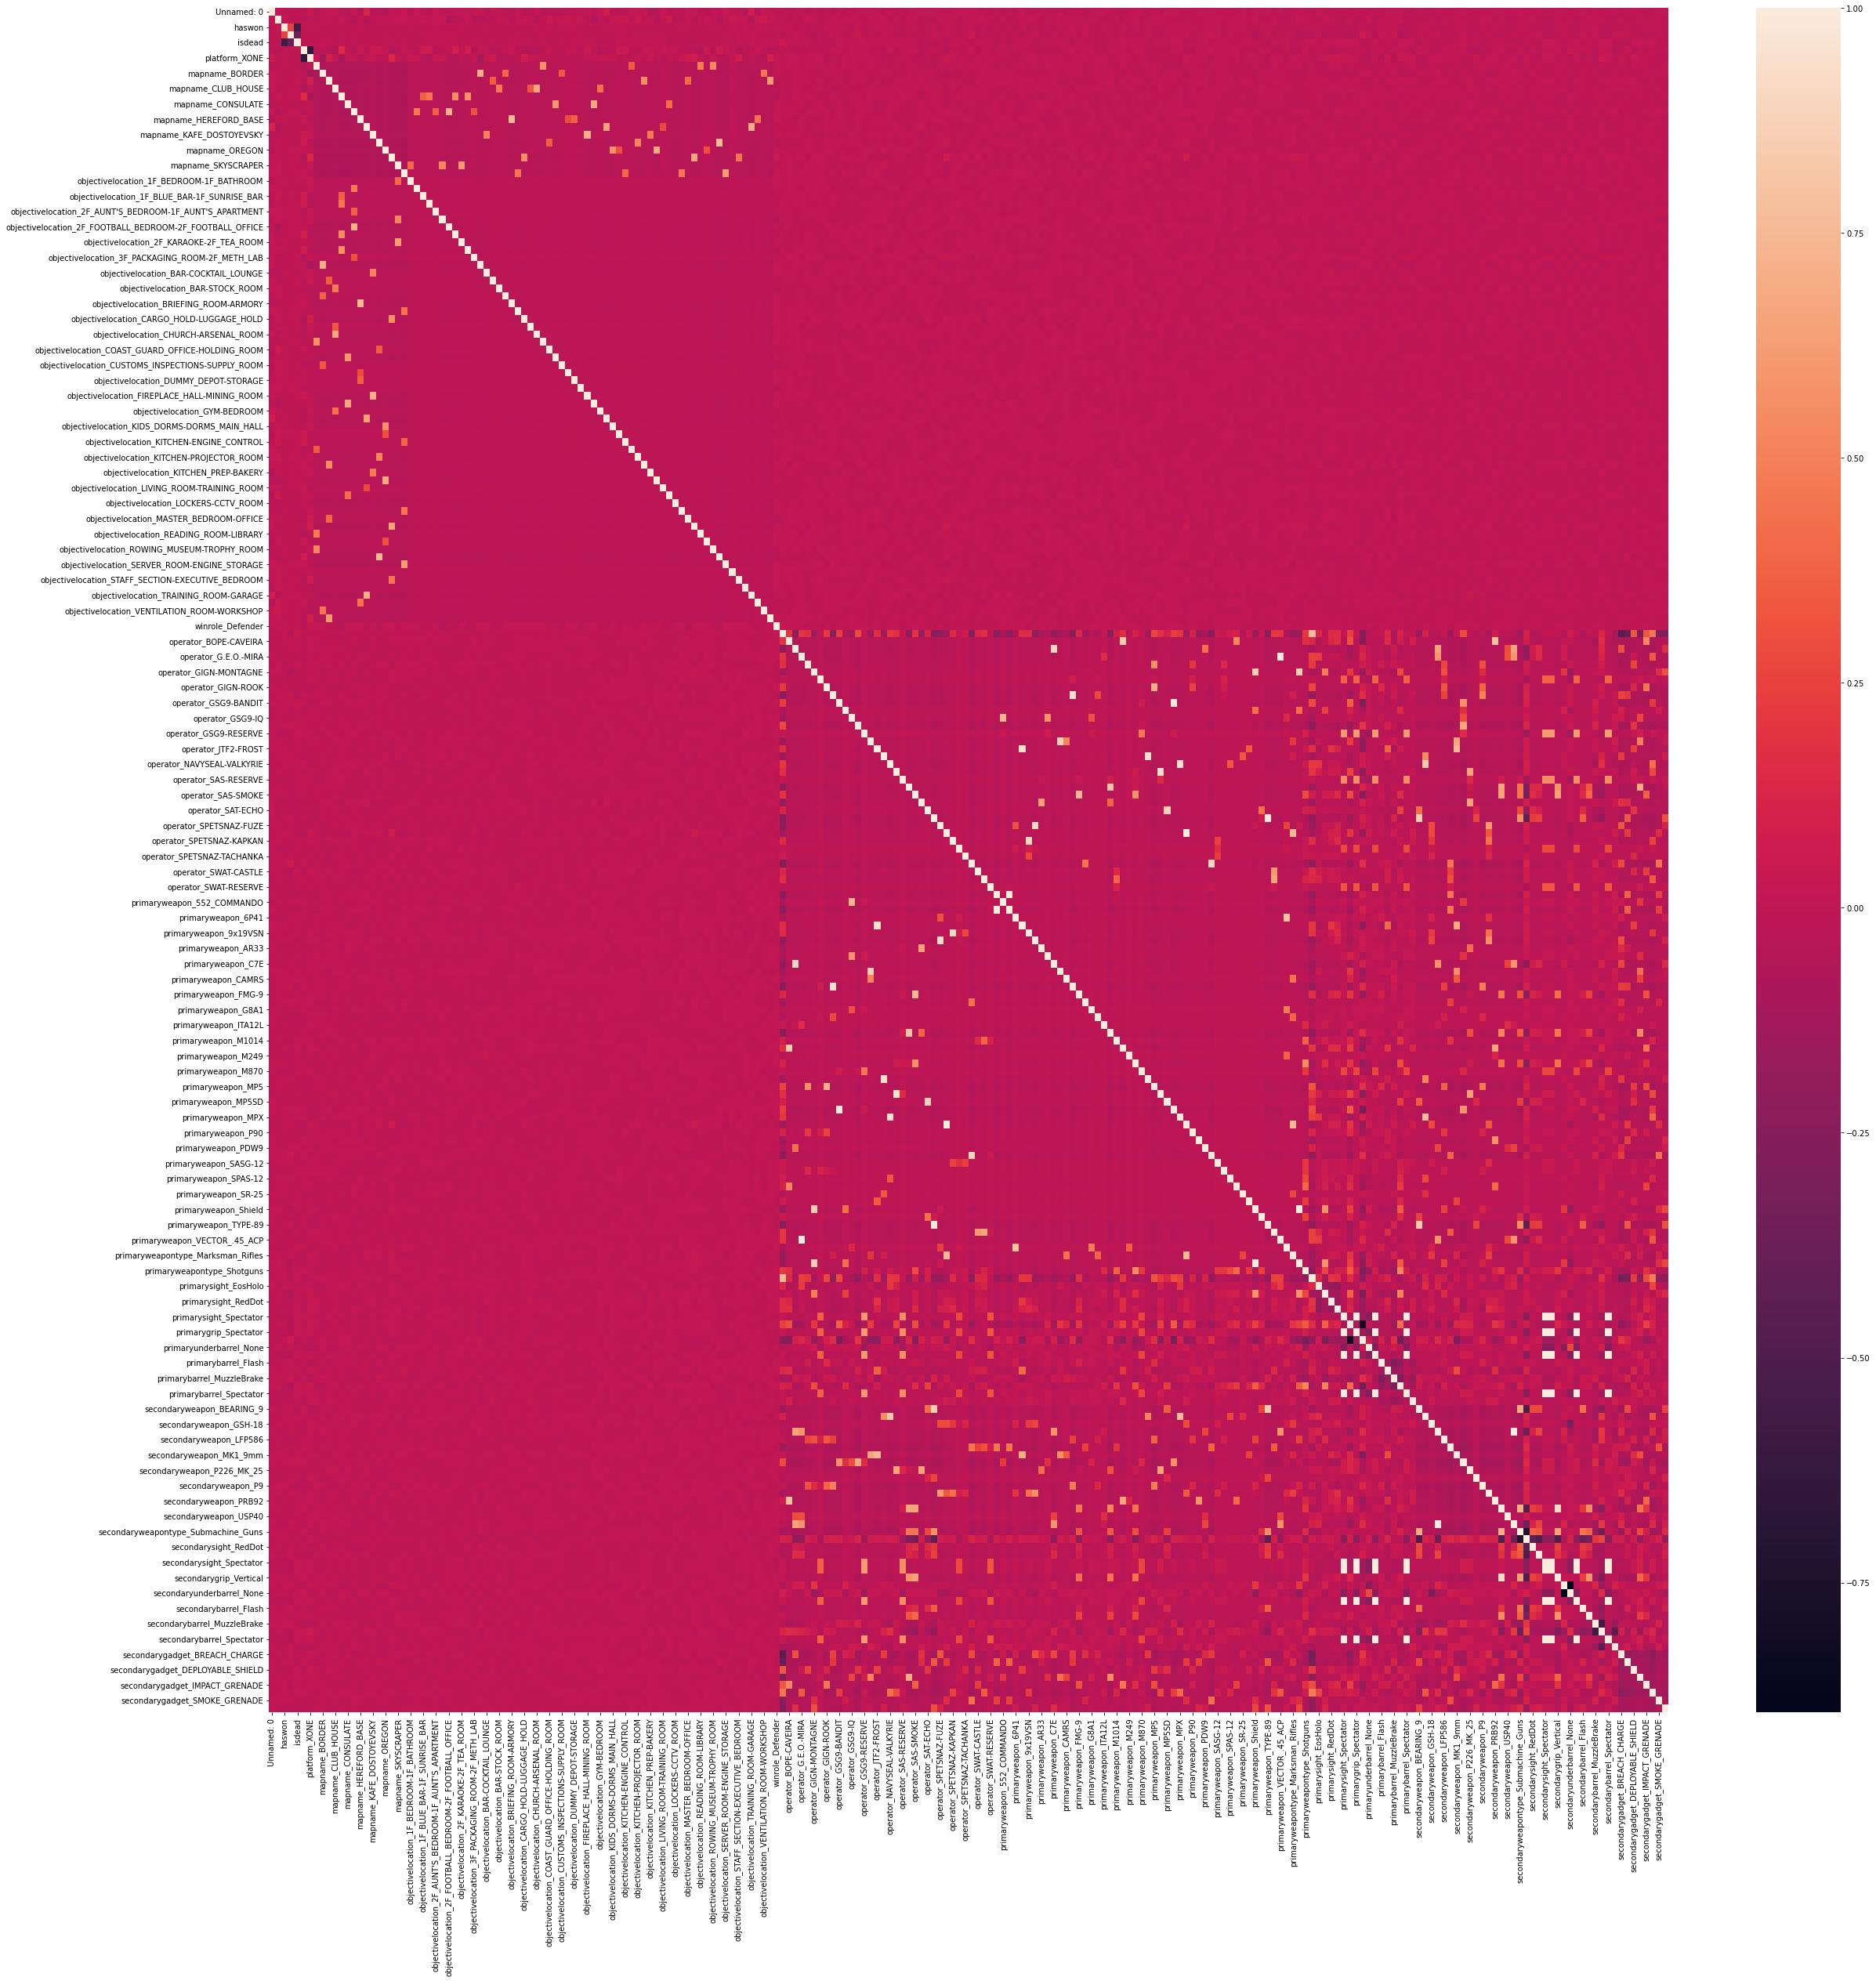

In [7]:
# make a heatmap

plt.figure(figsize=(40, 40))
sns.heatmap(dummy_bomb.corr())

### Check the averages of the data
using pandas `describe` method

In [8]:
# first on the filtered data, to see which item is the most frequent in each variable

filtered.describe(include='all')

,Unnamed: 0,platform,gamemode,mapname,roundnumber,objectivelocation,winrole,role,haswon,operator,nbkills,isdead,primaryweapon,primaryweapontype,primarysight,primarygrip,primaryunderbarrel,primarybarrel,secondaryweapon,secondaryweapontype,secondarysight,secondarygrip,secondaryunderbarrel,secondarybarrel,secondarygadget
count,26257.000000,26257,26257,26257,26257.000000,26257,26257,26257,26257.000000,26257,26257.000000,26257.000000,26257,26257,26257,26257,26257,26257,26257,26257,26257,26257,26257,26257,26257
unique,NaN,3,1,16,NaN,59,2,2,NaN,35,NaN,NaN,46,6,6,4,3,7,16,3,5,3,4,7,9
top,NaN,PS4,BOMB,YACHT,NaN,SERVER_ROOM-CONTROL_ROOM,Defender,Defender,NaN,GSG9-JAGER,NaN,NaN,416-C_CARBINE,Assault_Rifles,Acog,Vertical,None,MuzzleBrake,P12,Pistols,None,None,None,None,BREACH_CHARGE
freq,NaN,11160,26257,2243,NaN,1038,13238,13154,NaN,1858,NaN,NaN,1866,12947,11850,16210,22118,7394,3840,21136,21961,24472,21363,15819,4607
mean,50082.616064,NaN,NaN,NaN,3.588491,NaN,NaN,NaN,0.508474,NaN,0.706859,0.709677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,28587.955300,NaN,NaN,NaN,2.042031,NaN,NaN,NaN,0.499938,NaN,0.918086,0.453920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,54.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,25900.000000,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,50528.000000,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,74617.000000,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,1.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
dummy_bomb.describe()

,Unnamed: 0,roundnumber,haswon,nbkills,isdead,platform_PS4,platform_XONE,mapname_BARTLETT_U.,mapname_BORDER,mapname_CHALET,mapname_CLUB_HOUSE,mapname_COASTLINE,mapname_CONSULATE,mapname_FAVELAS,mapname_HEREFORD_BASE,mapname_HOUSE,mapname_KAFE_DOSTOYEVSKY,mapname_KANAL,mapname_OREGON,mapname_PLANE,mapname_SKYSCRAPER,mapname_YACHT,objectivelocation_1F_BEDROOM-1F_BATHROOM,objectivelocation_1F_BIKER'S_APARTMENT-1F_BIKER'S_BEDROOM,objectivelocation_1F_BLUE_BAR-1F_SUNRISE_BAR,objectivelocation_1F_KITCHEN-1F_SERVICE_ENTRANCE,objectivelocation_2F_AUNT'S_BEDROOM-1F_AUNT'S_APARTMENT,objectivelocation_2F_EXHIBITION-2F_WORK_OFFICE,objectivelocation_2F_FOOTBALL_BEDROOM-2F_FOOTBALL_OFFICE,objectivelocation_2F_HOOKAH_LOUNGE-2F_BILLIARDS_ROOM,objectivelocation_2F_KARAOKE-2F_TEA_ROOM,objectivelocation_2F_PENTHOUSE-2F_THEATER,objectivelocation_3F_PACKAGING_ROOM-2F_METH_LAB,objectivelocation_ARMORY_LOCKERS-ARCHIVES,objectivelocation_BAR-COCKTAIL_LOUNGE,objectivelocation_BAR-GAMING_ROOM,objectivelocation_BAR-STOCK_ROOM,objectivelocation_BATHROOM-TELLERS,objectivelocation_BRIEFING_ROOM-ARMORY,objectivelocation_CAFETERIA-STAFF_DORMITORY,objectivelocation_CARGO_HOLD-LUGGAGE_HOLD,objectivelocation_CCTV_ROOM-CASH_ROOM,objectivelocation_CHURCH-ARSENAL_ROOM,objectivelocation_CLASSROOM-LIBRARY,objectivelocation_COAST_GUARD_OFFICE-HOLDING_ROOM,objectivelocation_CONSUL_OFFICE-MEEETING_ROOM,objectivelocation_CUSTOMS_INSPECTIONS-SUPPLY_ROOM,objectivelocation_DINING_ROOM-KIDS_BEDROOM,objectivelocation_DUMMY_DEPOT-STORAGE,objectivelocation_EXECUTIVE_LOUNGE-CEO_OFFICE,objectivelocation_FIREPLACE_HALL-MINING_ROOM,objectivelocation_GARAGE-CAFETERIA,objectivelocation_GYM-BEDROOM,objectivelocation_KID'S_BEDROOM-WORKSHOP,objectivelocation_KIDS_DORMS-DORMS_MAIN_HALL,objectivelocation_KITCHEN-DINING_HALL,objectivelocation_KITCHEN-ENGINE_CONTROL,objectivelocation_KITCHEN-PIANO_ROOM,objectivelocation_KITCHEN-PROJECTOR_ROOM,objectivelocation_KITCHEN-TROPHY_ROOM,objectivelocation_KITCHEN_PREP-BAKERY,objectivelocation_LAUDRY_ROOM-SUPPLY_ROOM,objectivelocation_LIVING_ROOM-TRAINING_ROOM,objectivelocation_LOBBY-PRESS_ROOM,objectivelocation_LOCKERS-CCTV_ROOM,objectivelocation_MAPS_ROOM-COCKPIT,objectivelocation_MASTER_BEDROOM-OFFICE,objectivelocation_MEETING_ROOM-EXECUTIVE_OFFICE,objectivelocation_READING_ROOM-LIBRARY,objectivelocation_REAR_STAGE-WATCH_TOWER,objectivelocation_ROWING_MUSEUM-TROPHY_ROOM,objectivelocation_SERVER_ROOM-CONTROL_ROOM,objectivelocation_SERVER_ROOM-ENGINE_STORAGE,objectivelocation_STAFF_ROOM-OPEN_AREA,objectivelocation_STAFF_SECTION-EXECUTIVE_BEDROOM,objectivelocation_TELLERS'_OFFICE-ARCHIVES,objectivelocation_TRAINING_ROOM-GARAGE,objectivelocation_TV_ROOM-KITCHEN,objectivelocation_VENTILATION_ROOM-WORKSHOP,objectivelocation_WINE_CELLAR-SNOWMOBILE_GARAGE,winrole_Defender,role_Defender,operator_BOPE-CAVEIRA,operator_G.E.O.-JACKAL,operator_G.E.O.-MIRA,operator_GIGN-DOC,operator_GIGN-MONTAGNE,operator_GIGN-RESERVE,operator_GIGN-ROOK,operator_GIGN-TWITCH,operator_GSG9-BANDIT,operator_GSG9-BLITZ,operator_GSG9-IQ,operator_GSG9-JAGER,operator_GSG9-RESERVE,operator_JTF2-BUCK,operator_JTF2-FROST,operator_NAVYSEAL-BLACKBEARD,operator_NAVYSEAL-VALKYRIE,operator_SAS-MUTE,operator_SAS-RESERVE,operator_SAS-SLEDGE,operator_SAS-SMOKE,operator_SAS-THATCHER,operator_SAT-ECHO,operator_SAT-HIBANA,operator_SPETSNAZ-FUZE,operator_SPETSNAZ-GLAZ,operator_SPETSNAZ-KAPKAN,operator_SPETSNAZ-RESERVE,operator_SPETSNAZ-TACHANKA,operator_SWAT-ASH,operator_SWAT-CASTLE,operator_SWAT-PULSE,operator_SWAT-RESERVE,operator_SWAT-THERMITE,primaryweapon_552_COMMANDO,primaryweapon_556XI,primaryweapon_6P41,primaryweapon_9mm_C1,primaryweapon_9x19VSN,primaryweapon_AK-12,primaryweapon_AR33,primaryweapon_AUG_A2,primaryweapon_C7E,primaryweapon_C8-SFW,primaryweapon_CAMRS,primaryweapon_F2,primaryweapon_FMG-9,primaryweapon_G36C,primaryweapon_G8A1,primaryweapon_HK417,primaryweapon_ITA12L,primaryweapon_L85A2,primaryweapon_M1014,primaryweapon_M12,primaryweapon_M249,primaryweapon_M590A1,primaryweapon_M870

many of the `objectives` have very low means and standard deviation. 

this is to be expected, as they are sometimes not chosen at all, and the ratio of match-> to mapname-> to objective location is sum(mapname) x count(location). meaning that the chances a given map is chosen is somewhat random, and the locations within each map, while generally predictable in competitive play, are less chosen because of the randomness of the map. 

that being said, i still want to include them in my analysis, because though popular opinion is that certain locations are easier to defend against, and should always be chosen, there may be a higher win rate on other locations.

there are many `RESERVE` operators. i want to see what they could be. they have very low mean and STD, they might be worth removing.

i will look at the most recent datas unique values to see if the name has changed

# Double Checkup

i want to use the last data set in the original data to re verify that the columns are mostly the same

while at it, i will save a smaller version of the csv file for others to reproduce my work

In [10]:
last_slice = pd.read_csv('r6s_data/datadump_s5-021.csv',  nrows=100000)
last_slice.to_csv('data_last_slice.csv')

last_set = pd.read_csv('data_last_slice.csv')
last_set['operator'].unique()

array(['G.E.O.-MIRA', 'SPETSNAZ-RESERVE', 'GSG9-BANDIT', 'SWAT-ASH',
       'GIGN-TWITCH', 'SAT-HIBANA', 'GIGN-MONTAGNE', 'SPETSNAZ-TACHANKA',
       'SWAT-CASTLE', 'SPETSNAZ-GLAZ', 'SWAT-PULSE', 'BOPE-CAVEIRA',
       'GSG9-IQ', 'GSG9-JAGER', 'NAVYSEAL-VALKYRIE', 'SPETSNAZ-KAPKAN',
       'SPETSNAZ-FUZE', 'JTF2-FROST', 'SAS-SLEDGE', 'SWAT-THERMITE',
       'GIGN-DOC', 'SAS-MUTE', 'GIGN-ROOK', 'BOPE-CAPITAO', 'JTF2-BUCK',
       'SAS-SMOKE', 'NAVYSEAL-BLACKBEARD', 'G.E.O.-JACKAL',
       'SAS-THATCHER', 'GSG9-BLITZ', 'GSG9-RESERVE', 'SAS-RESERVE',
       'SWAT-RESERVE', 'SAT-ECHO', 'GIGN-RESERVE'], dtype=object)

In [11]:
first = np.sort(data['operator'].unique())
last = np.sort(last_set['operator'].unique())

compare_operators = pd.DataFrame([first, last])

In [12]:
compare_operators

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,BOPE-CAPITAO,BOPE-CAVEIRA,G.E.O.-JACKAL,G.E.O.-MIRA,GIGN-DOC,GIGN-MONTAGNE,GIGN-RESERVE,GIGN-ROOK,GIGN-TWITCH,GSG9-BANDIT,GSG9-BLITZ,GSG9-IQ,GSG9-JAGER,GSG9-RESERVE,JTF2-BUCK,JTF2-FROST,NAVYSEAL-BLACKBEARD,NAVYSEAL-VALKYRIE,SAS-MUTE,SAS-RESERVE,SAS-SLEDGE,SAS-SMOKE,SAS-THATCHER,SAT-ECHO,SAT-HIBANA,SPETSNAZ-FUZE,SPETSNAZ-GLAZ,SPETSNAZ-KAPKAN,SPETSNAZ-RESERVE,SPETSNAZ-TACHANKA,SWAT-ASH,SWAT-CASTLE,SWAT-PULSE,SWAT-RESERVE,SWAT-THERMITE
1,BOPE-CAPITAO,BOPE-CAVEIRA,G.E.O.-JACKAL,G.E.O.-MIRA,GIGN-DOC,GIGN-MONTAGNE,GIGN-RESERVE,GIGN-ROOK,GIGN-TWITCH,GSG9-BANDIT,GSG9-BLITZ,GSG9-IQ,GSG9-JAGER,GSG9-RESERVE,JTF2-BUCK,JTF2-FROST,NAVYSEAL-BLACKBEARD,NAVYSEAL-VALKYRIE,SAS-MUTE,SAS-RESERVE,SAS-SLEDGE,SAS-SMOKE,SAS-THATCHER,SAT-ECHO,SAT-HIBANA,SPETSNAZ-FUZE,SPETSNAZ-GLAZ,SPETSNAZ-KAPKAN,SPETSNAZ-RESERVE,SPETSNAZ-TACHANKA,SWAT-ASH,SWAT-CASTLE,SWAT-PULSE,SWAT-RESERVE,SWAT-THERMITE


they are the same.

i want to double check the dates, that they are different

In [13]:
# double check the dates, that they are different
last_set['dateid'].unique()

array([20170506], dtype=int64)

In [14]:
# rename first column, to filter the Dataframe

dummy_bomb.iloc[0]

Unnamed: 0                        54
roundnumber                        1
haswon                             0
nbkills                            0
isdead                             1
                                  ..
secondarygadget_FRAG_GRENADE       0
secondarygadget_IMPACT_GRENADE     0
secondarygadget_NITRO_CELL         0
secondarygadget_SMOKE_GRENADE      0
secondarygadget_STUN_GRENADE       0
Name: 54, Length: 222, dtype: int64

In [15]:
dummy_bomb.rename(columns={'Unnamed: 0':'wins'}, inplace=True )

In [16]:
for column in dummy_bomb:
    print(dummy_bomb[[column]].mean())

wins    50082.616064
dtype: float64
roundnumber    3.588491
dtype: float64
haswon    0.508474
dtype: float64
nbkills    0.706859
dtype: float64
isdead    0.709677
dtype: float64
platform_PS4    0.42503
dtype: float64
platform_XONE    0.355677
dtype: float64
mapname_BARTLETT_U.    0.05728
dtype: float64
mapname_BORDER    0.071905
dtype: float64
mapname_CHALET    0.060174
dtype: float64
mapname_CLUB_HOUSE    0.050425
dtype: float64
mapname_COASTLINE    0.06543
dtype: float64
mapname_CONSULATE    0.064935
dtype: float64
mapname_FAVELAS    0.063221
dtype: float64
mapname_HEREFORD_BASE    0.0553
dtype: float64
mapname_HOUSE    0.05827
dtype: float64
mapname_KAFE_DOSTOYEVSKY    0.042846
dtype: float64
mapname_KANAL    0.069086
dtype: float64
mapname_OREGON    0.051339
dtype: float64
mapname_PLANE    0.075523
dtype: float64
mapname_SKYSCRAPER    0.071524
dtype: float64
mapname_YACHT    0.085425
dtype: float64
objectivelocation_1F_BEDROOM-1F_BATHROOM    0.011883
dtype: float64
objectivelocatio

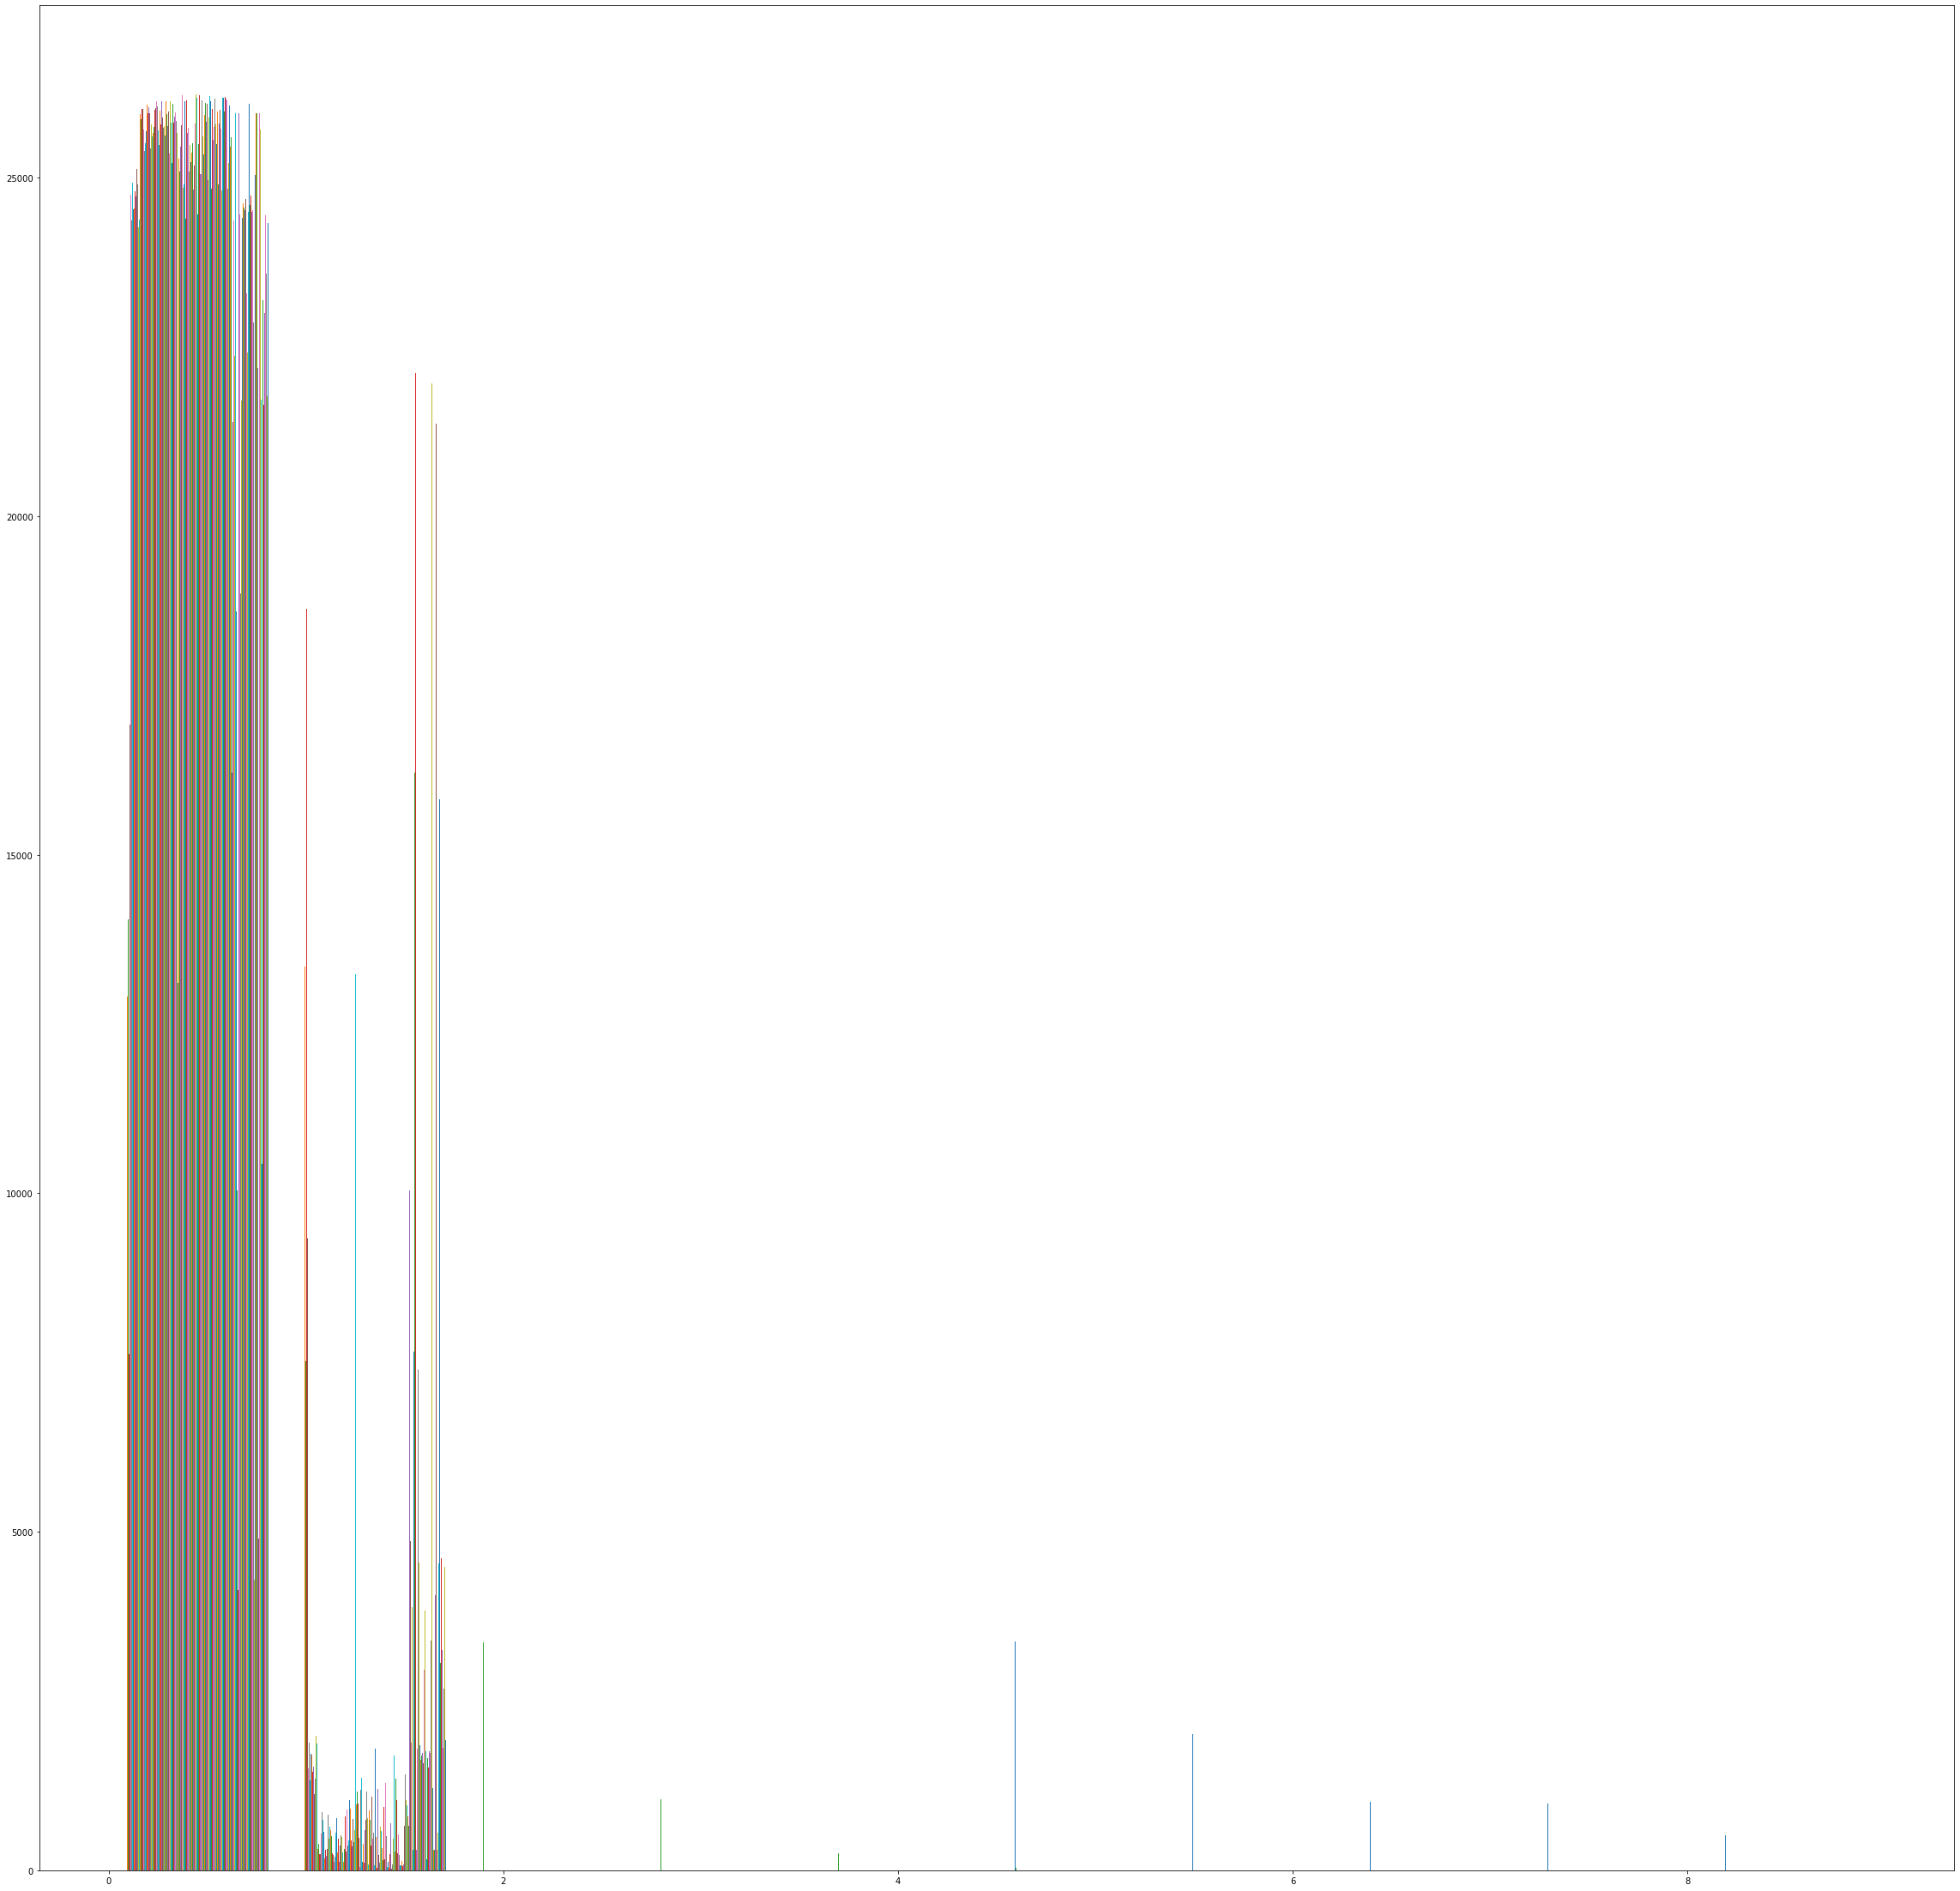

In [17]:
for_hist_plot = dummy_bomb.drop('wins', axis=1)
plt.figure(figsize=(40, 40))
plt.hist(for_hist_plot, label=for_hist_plot.columns)
plt.show()

#### that's hard to read


In [18]:
# make a data frame with no outliers, for a more readable bar chart
no_outliers = for_hist_plot[for_hist_plot.columns[for_hist_plot.mean(axis=0) > 0.2]]

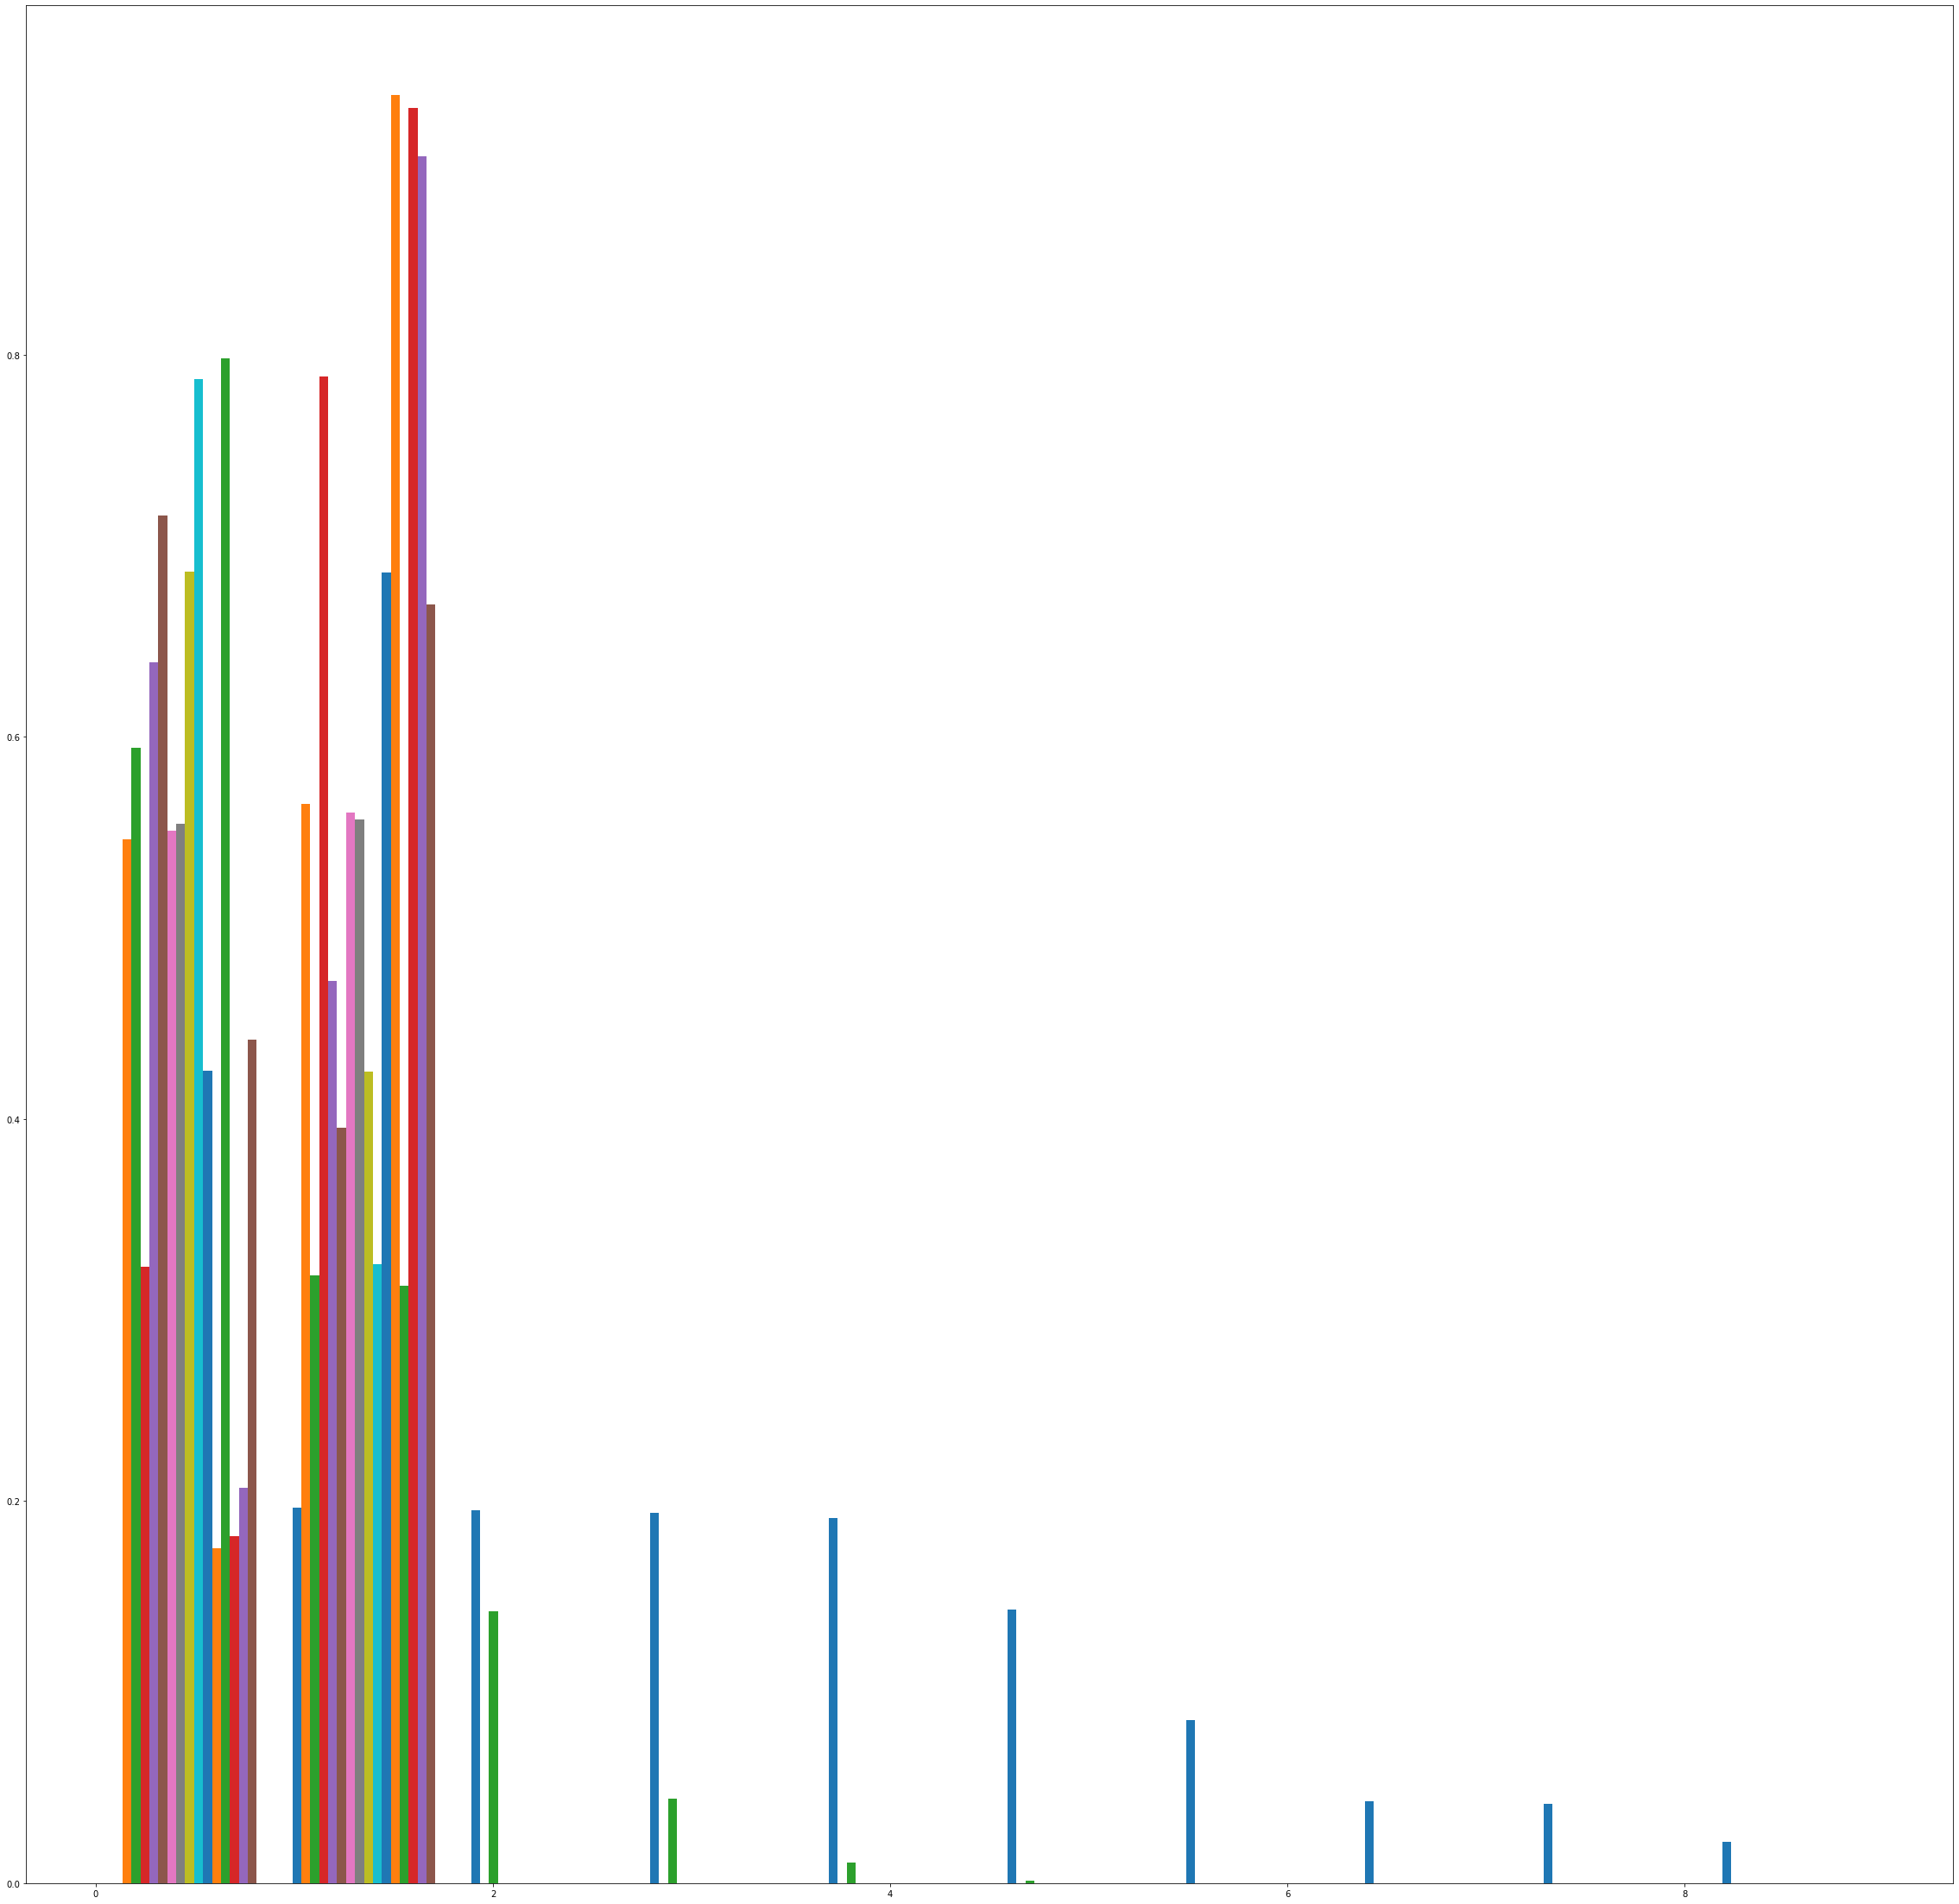

In [20]:
# hist plot with no outliers
plt.figure(figsize=(40, 40))
plt.hist(no_outliers, density=True)
plt.show()

most of the data appears to be in the less than 2 range, and doesn't appear to have a normal curve. this may present a challenge

#### double check on the target value

In [21]:
only_bomb['haswon'].describe()

count    26257.000000
mean         0.508474
std          0.499938
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: haswon, dtype: float64

the mean being approximately 0.50 implies that the target variable does not seem to have a major imbalance issue. we can use it as is

# Data cleaning

1) `dateid` is arbitrary, and useless. later date data may be different, but i will only find that out by experimenting. 
`roundduration`,  `clearancelevel` and `skillrank` are outcomes of wins, expected to be **heavily correlated**, so i will drop them. i will drop `team` as i am not certain, and have no way to be certain what it means, and i don't want data that i'm not certain about (especially considering how much other data is available)

2) 'haswon' is our target variable

3) ALL the remaining variables here are categorical. need to use sklearn `OneHotEncoder`, which also means there is no need to scale the variables

there truly is 0 correlation. this will be difficult to work with

## 1) 2)

In [22]:
#train test split, for later cross validation
y = only_bomb['haswon']
x = only_bomb.drop(['haswon', 'matchid', 'dateid', 'roundduration', 'endroundreason', 'clearancelevel', 'skillrank'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

## 3)

In [23]:
# one hot encoding test and training sets
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', drop='first')

ohe.fit(x_train)
x_train_ohe = ohe.transform(x_train).toarray()
x_test_ohe = ohe.transform(x_test).toarray()

# Creating this DataFrame to show the result of the ohe, and plotting
ohe_train = pd.DataFrame(x_train_ohe, columns=ohe.get_feature_names_out(x_train.columns))

C:\Users\yonic\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [24]:
# use decision tree classifier for first model. 
# i want several leaf nodes, and entropy, because i assume there will be many positive values
from sklearn.tree import DecisionTreeClassifier

In [25]:
clf = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=7)
clf.fit(x_train_ohe, y_train)

DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=7)

let's see how well the clf model did

In [26]:
# make a function to output the classification report and consfusion matrix for model assesment

def prediction_scores(y_t, y_p):
    """print a confusion matrix, and classification report(precision, recall, F1 score) for a model prediction"""
    print("classification report")
    print(classification_report(y_t, y_p))
    plt.figure(figsize=[8,8])
    sns.heatmap(confusion_matrix(y_t, y_p), annot=True)

classification report
              precision    recall  f1-score   support

           0       0.68      1.00      0.81      6447
           1       1.00      0.55      0.71      6682

    accuracy                           0.77     13129
   macro avg       0.84      0.77      0.76     13129
weighted avg       0.84      0.77      0.76     13129



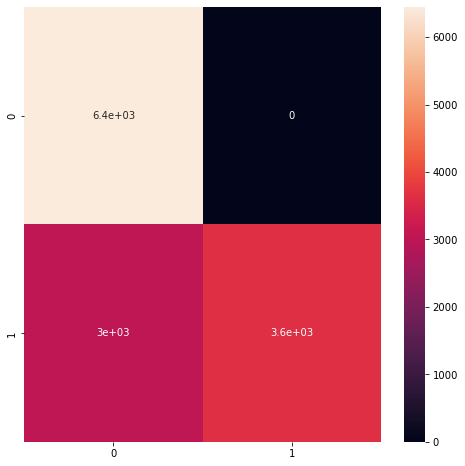

In [27]:
# get accuracy score, confusion matrix and classification report
y_preds = clf.predict(x_test_ohe)

prediction_scores(y_test, y_preds)

0.71
and more type 2 errors, which is preferred for my case

that's pretty good. i wonder if i can do better

In [28]:
# GridSearchCV
# get the ideal set of parameters from what i hypothesisze are good options
from sklearn.model_selection import GridSearchCV

clf_grid = DecisionTreeClassifier()

In [29]:
# the hyper parameters i used above seemed to work, so i will include them with the grid search.
# i will also include smaller tree depths, different minimal splits, but not too many, as that would take too long to compute
# gini, because labeling the data might be more important in my case than avoiding entropy

parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 7],
    'min_samples_split': [2, 4, 8, 16]
}

grid_search_DTree = GridSearchCV(clf_grid, parameter_grid, cv=3)
grid_search_DTree.fit(x_train_ohe, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 7],
                         'min_samples_split': [2, 4, 8, 16]})

In [30]:
import joblib

with open('pickle_files/clf_grid.pkl', 'wb') as clfpkl:
    joblib.dump(grid_search_DTree, clfpkl)

In [31]:
with open('pickle_files/clf_grid.pkl', 'rb') as clfpkl:
    clf_cross = joblib.load(clfpkl)

In [32]:
clf_cross.best_params_

{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 2}

the best parameters appear to be
`{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 2}`

In [33]:
clf_after_grid = DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_split=4)
clf_after_grid.fit(x_train_ohe, y_train)

after_grid_predict = clf_after_grid.predict(x_test_ohe)

classification report
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      6447
           1       1.00      0.75      0.85      6682

    accuracy                           0.87     13129
   macro avg       0.89      0.87      0.87     13129
weighted avg       0.90      0.87      0.87     13129



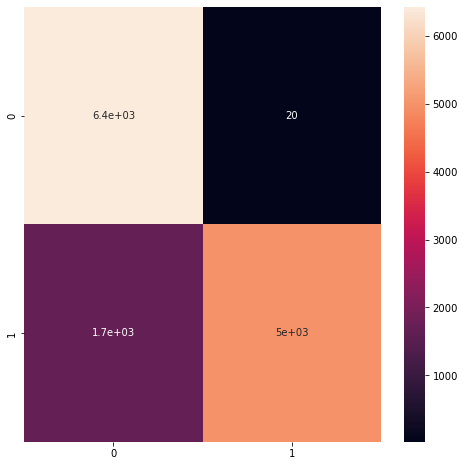

In [34]:
prediction_scores(y_test, after_grid_predict)

The model seems to be good. 

there are more false negatives than false positives. which is what we want, the model should be more cautious and 
telling a player they might lose, when they'll win, is better than the oposite 

the f1 score is 0.85, that's pretty good as well. this model 


## Double Check first model

let's use the `last_set` data again, to double check the model

In [35]:
# make a test x and y set with the last csv file. and add an empty column for the 0 column that is in the training data

last_bomb = last_set.loc[last_set['gamemode'] == 'BOMB']
last_y = last_bomb['haswon']
last_x = last_bomb.drop(['haswon', 'matchid', 'dateid', 'roundduration', 'endroundreason', 'clearancelevel', 'skillrank'], axis=1)
last_x['Unnamed: 0'] = np.ones(len(last_x['isdead']), dtype=np.int64)

# check the columns names to make sure they are the same order. if not i have to fix them
print(last_x.columns)
print(x_train.columns)

Index(['Unnamed: 0', 'platform', 'gamemode', 'mapname', 'roundnumber',
       'objectivelocation', 'winrole', 'role', 'team', 'operator', 'nbkills',
       'isdead', 'primaryweapon', 'primaryweapontype', 'primarysight',
       'primarygrip', 'primaryunderbarrel', 'primarybarrel', 'secondaryweapon',
       'secondaryweapontype', 'secondarysight', 'secondarygrip',
       'secondaryunderbarrel', 'secondarybarrel', 'secondarygadget'],
      dtype='object')
Index(['Unnamed: 0', 'platform', 'gamemode', 'mapname', 'roundnumber',
       'objectivelocation', 'winrole', 'role', 'team', 'operator', 'nbkills',
       'isdead', 'primaryweapon', 'primaryweapontype', 'primarysight',
       'primarygrip', 'primaryunderbarrel', 'primarybarrel', 'secondaryweapon',
       'secondaryweapontype', 'secondarysight', 'secondarygrip',
       'secondaryunderbarrel', 'secondarybarrel', 'secondarygadget'],
      dtype='object')


In [36]:
# reorganize all the columns so i can use OHE on them
last_x = last_x[['Unnamed: 0', 'platform', 'gamemode', 'mapname', 'roundnumber',
       'objectivelocation', 'winrole', 'role', 'team', 'operator', 'nbkills',
       'isdead', 'primaryweapon', 'primaryweapontype', 'primarysight',
       'primarygrip', 'primaryunderbarrel', 'primarybarrel', 'secondaryweapon',
       'secondaryweapontype', 'secondarysight', 'secondarygrip',
       'secondaryunderbarrel', 'secondarybarrel', 'secondarygadget']]

C:\Users\yonic\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


classification report
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     13588
           1       0.99      0.76      0.86     14055

    accuracy                           0.88     27643
   macro avg       0.90      0.88      0.87     27643
weighted avg       0.90      0.88      0.87     27643



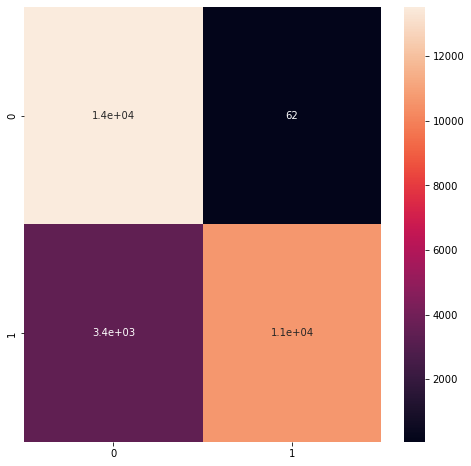

In [37]:
last_ohe = ohe.transform(last_x).toarray()

last_pred = clf_after_grid.predict(last_ohe)
prediction_scores(last_y, last_pred)

the results of this 2017  data set, (which ubisoft knows about, and has since compensated for) is that being a defender is the biggest determining factor to winning more matches.

0.86 f1 score is pretty good, but if i can get one point better, that would give me more confidence

### Next model, KNN
lets use GridSearchCV again


In [38]:
#baseline knn model
from sklearn.neighbors import KNeighborsClassifier

# since i have so many 0 values (a sparse matrix) i have to use 'brute' method of weights, RAM heavy, but the only way i can
# get anything useful out of KNN

knn_baseline = KNeighborsClassifier(algorithm='brute')

knn_baseline.fit(x_train_ohe, y_train)

KNeighborsClassifier(algorithm='brute')

In [39]:
# pickle

with open('pickle_files/knn_base.pkl', 'wb') as knnpkl:
    joblib.dump(knn_baseline, knnpkl)

In [40]:
with open('pickle_files/knn_base.pkl', 'rb') as knnpkl:
    knn_base = joblib.load(knnpkl)

classification report
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      6447
           1       0.92      0.84      0.88      6682

    accuracy                           0.88     13129
   macro avg       0.88      0.88      0.88     13129
weighted avg       0.88      0.88      0.88     13129



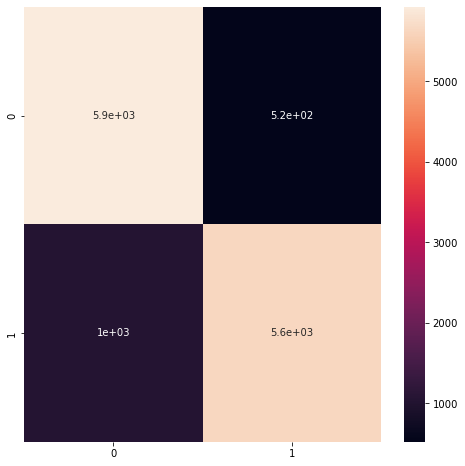

In [41]:
knn_predict = knn_base.predict(x_test_ohe)

prediction_scores(y_test, knn_predict)

the f1 score was 0.88. a slight improvement DecisionTree model, but more type 1 errors. Going to try `GridSearch` on this model, hopefully it will perform even better

In [42]:
# make a KNN model with gridsearch to get best parameters
# my choices of hyper parameters explained: 3, or 7 neighbors, 
# to try an odd number of slightly more or less thanthe default of 5
# the default algorithm, searches for the best of brute force, ball_tree, or kd_tree. i don't want it to use brute force
# for 'p' i want to try the manhattan and euclidian distance. either might perform better


# knn_params = {
#     'weights': ['distance'],
#     'n_neighbors': [3, 7],
#     'algorithm': ['ball_tree', 'kd_tree'],
#     'p':[1, 2]
# }

# knn = KNeighborsClassifier()

# grid_search_knn = GridSearchCV(knn, knn_params, cv=3)
# grid_search_knn.fit(x_train_ohe, y_train)

In [43]:
# with open('pickle_files/knn_grid.pkl', 'wb') as knnpkl:
#     joblib.dump(grid_search_knn, knnpkl)

In [44]:
# with open('pickle_files/knn_grid.pkl', 'rb') as knnpkl:
#     knn_grid = joblib.load(knnpkl)

In [45]:
# knn_grid.best_params_

### Random Forest model

using RandomForest to get the best of both worlds

In [46]:
# RandomForest and Pipeline, because i want to refactor my final model into a pipeline
# hopefully send it to some other players :->
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

random_forest_one = RandomForestClassifier(random_state=123)
random_pipe = Pipeline([('RF', RandomForestClassifier(random_state=123))])

In [47]:
# base randomForest model

random_forest_one.fit(x_train_ohe, y_train)
random_forest_one.score(x_test_ohe, y_test)

0.982405362175337

In [48]:
# get base RnadomForest y predict
random_one_pred = random_forest_one.predict(x_test_ohe)

classification report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      6447
           1       0.98      0.99      0.98      6682

    accuracy                           0.98     13129
   macro avg       0.98      0.98      0.98     13129
weighted avg       0.98      0.98      0.98     13129



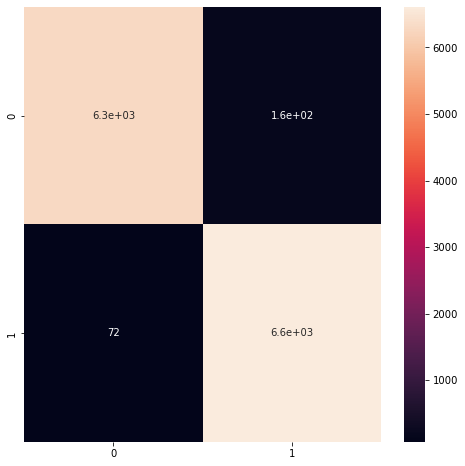

In [49]:
prediction_scores(y_test, random_one_pred)

amazing F1 score!!! **BUT** i want more type 2 errors than type 1, and we have the oposite here.

will have to try for a more optomized model

In [50]:
# gridsearch RandomForest model
grid = [{'RF__max_depth': [4, 5, 6], 
         'RF__min_samples_split': [2, 5], 
         'RF__min_samples_leaf': [1, 3, 5]}]

grid_forest = GridSearchCV(estimator=random_pipe, param_grid=grid, scoring='accuracy', cv=5)

In [ ]:
grid_forest.fit(x_train_ohe, y_train)
grid_forest.score(x_test_ohe, y_test)

In [ ]:
grid_forest.best_params_

{'RF__max_depth': 6, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2}

In [ ]:
# RandomForest model with best parameters from gridsearch
final_forest = RandomForestClassifier(max_depth=6, min_samples_leaf=1, min_samples_split=2)

In [ ]:
# fit the final model
final_forest.fit(x_train_ohe, y_train)

In [ ]:
# pickle the final model
with open('pickle_files/forest_final.pkl', 'wb') as fopkl:
    joblib.dump(final_forest, fopkl)

In [ ]:
with open('pickle_files/forest_final.pkl', 'rb') as fopkl:
    fo_fin = joblib.load('forest_final.pkl')

In [ ]:
# get final model y predict
final_forest_pred = fo_fin.predict(x_test_ohe)

In [ ]:
# get scores of final model
prediction_scores(y_test, final_forest_pred)

worse F1 score is 0.72, but more type 2 errors than type 1 in the KNN model. however, the random forest is not as greedy as the DecisionTree model, therefore
I can be more confident that there is less over-fitting

ti be sure, i will test it on the holdout set from the `last_ohe` data

In [ ]:
# make a dataframe to get data for a bar chart, for my presentation
display_df = pd.DataFrame(data=[final_forest.feature_importances_ ], columns=ohe_train.columns.values)
display_df.head(15)

let's see which features are most important

In [ ]:
# take the most useful columns to display
actually_useful = display_df.loc[:, (display_df.iloc[-1] > 0.01)]

# sort actually useful


actually_useful

In [ ]:
# make a barplot of the useful features
plt.figure(figsize=(10, 10))
plt.xticks(rotation=45)
sns.barplot(data=actually_useful, palette="dark:#5A9_r")